In [110]:
import pandas as pd
import numpy as np
import torch 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import glob, os, pickle
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torch_geometric.data import Data, Dataset
import dgl
from torch_geometric.utils import dropout_edge

In [2]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling, GATConv, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [4]:
device 

device(type='cuda', index=2)

In [5]:
x = torch.tensor([1,0,1,1,0,1,1])
print(x.shape)
print(F.one_hot(x))

torch.Size([7])
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]])


In [6]:
sophie_data = pd.read_pickle("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/graph_dataset/graph_dataset.pkl")

# Need to define the data class 
- Here focus mainly on the get() method. We don't need to process anything
- We also return masks for each graph, that will help with training 
- Actually, no masks. Inductive training.

In [7]:
class WSI_Graph_Class(Dataset):
    
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform)
        self.root_dir = root
        self.WSI_df = pd.read_csv(root) #get the WSI metadata
        self.masks = {} #map node num -> train/val/test masks
        self.create_all_masks()
        
    def create_all_masks(self):
        
        for idx in tqdm(range(len(self.WSI_df["sample_id"]))):
            path = self.WSI_df["path"].iloc[idx]
            
            #this is the graph. We also need to return the training/validation/testing masks 
            data = torch.load(path)
            nodes = [i for i in range(data.x.shape[0])] #node 0 is in 0th pos, 1 in 1, and so on 
            
            #all of the masks 
            train_mask = [False] * len(nodes)
            val_mask = [False] * len(nodes)
            test_mask = [False] * len(nodes)
            self.create_mask(nodes, train_mask, val_mask, test_mask)
            #now add them to dictionary
            self.masks[idx] = [train_mask, val_mask, test_mask]
        
        
    def create_mask(self, nodes, train_mask, val_mask, test_mask):        
        #create train/test/val nodes (75/25)
        train, test = train_test_split(nodes)
        test, val = train_test_split(test)
        
        #now create masks
        for i in range(len(nodes)):
            if i in train: 
                train_mask[i] = True 
                
        for i in range(len(nodes)):
            if nodes[i] in val: 
                val_mask[i] = True 
                
        for i in range(len(nodes)):
            if nodes[i] in test: 
                test_mask[i] = True 
                
    #just pass here, we aren't going to return any raw file names
    def raw_file_names(self):
        pass 
    #here we can return each of the WSI 
    def processed_file_names(self):
        return list(self.WSI_df["sample_id"])
    
    def len(self):
        return len(self.processed_file_names())
    
    #return the graph class for that idx 
    def get(self, idx):
        path = self.WSI_df["path"].iloc[idx]
        #this is the graph. We also need to return the training/validation/testing masks 
        data = torch.load(path)
        masks = self.masks[idx]
        train_mask = masks[0]
        val_mask = masks[1]
        test_mask = masks[2]
        return (data, torch.tensor(train_mask), torch.tensor(val_mask), torch.tensor(test_mask))

In [8]:
root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/graph_data/metadata.csv"

dataset = WSI_Graph_Class(root = root, transform = None, pre_transform = None, pre_filter = None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:02<00:00,  2.08s/it]


In [9]:
data = dataset.get(1)

In [10]:
training_data, testing_data = train_test_split(dataset)

In [11]:
training_data, val_data = train_test_split(training_data)

In [12]:
len(training_data)

16

# Data Sanity Check 

In [13]:
data

(Data(x=[14807, 2048], edge_index=[2, 113718], y=[14807]),
 tensor([ True, False,  True,  ..., False, False,  True]),
 tensor([False, False, False,  ..., False,  True, False]),
 tensor([False,  True, False,  ...,  True, False, False]))

In [14]:
sum(data[0].y == 1)/sum(data[0].y == 0)

tensor(0.3422)

In [15]:
graph = data[0]

In [16]:
graph.x

tensor([[0.3273, 0.3910, 0.2434,  ..., 0.1320, 0.3427, 0.1643],
        [0.3633, 0.4324, 0.2210,  ..., 0.1202, 0.3847, 0.1370],
        [0.3143, 0.3583, 0.1967,  ..., 0.1235, 0.3223, 0.1408],
        ...,
        [0.3529, 0.3735, 0.1997,  ..., 0.1163, 0.3923, 0.1283],
        [0.3563, 0.4631, 0.2405,  ..., 0.1372, 0.4183, 0.1589],
        [0.3672, 0.4138, 0.1967,  ..., 0.1255, 0.4014, 0.1501]])

In [17]:
sum(graph.y == 1)

tensor(3775)

In [18]:
val_mask = data[2]
train_mask = data[1]

In [19]:
sum(graph.y[train_mask] == 1)

tensor(2848)

In [20]:
sum(graph.y[train_mask] == 0)

tensor(8257)

In [21]:
list(graph.x[0])

[tensor(0.3273),
 tensor(0.3910),
 tensor(0.2434),
 tensor(0.2740),
 tensor(0.3770),
 tensor(0.1986),
 tensor(0.2894),
 tensor(0.2798),
 tensor(0.2180),
 tensor(0.2774),
 tensor(0.2228),
 tensor(0.2582),
 tensor(0.2934),
 tensor(0.2616),
 tensor(0.2318),
 tensor(0.2059),
 tensor(0.2734),
 tensor(0.1345),
 tensor(0.1636),
 tensor(0.2380),
 tensor(0.2302),
 tensor(0.1834),
 tensor(0.3113),
 tensor(0.2886),
 tensor(0.2514),
 tensor(0.3097),
 tensor(0.2254),
 tensor(0.2886),
 tensor(0.3816),
 tensor(0.1610),
 tensor(0.1412),
 tensor(0.1973),
 tensor(0.1213),
 tensor(0.2101),
 tensor(0.3877),
 tensor(0.1789),
 tensor(0.3065),
 tensor(0.2127),
 tensor(0.2804),
 tensor(0.2757),
 tensor(0.2536),
 tensor(0.4117),
 tensor(0.2085),
 tensor(0.2539),
 tensor(0.3148),
 tensor(0.3571),
 tensor(0.1836),
 tensor(0.3520),
 tensor(0.1677),
 tensor(0.1936),
 tensor(0.2729),
 tensor(0.1984),
 tensor(0.3282),
 tensor(0.2191),
 tensor(0.3683),
 tensor(0.3351),
 tensor(0.2762),
 tensor(0.1524),
 tensor(0.4025

In [22]:
#how similar are the patch embeddings 
sum((graph.x[0] - graph.x[8])**2) #so these embeddings are different

tensor(1.8893)

# Define Model 
- This mainly draws upon HIV project code 

In [23]:
torch.manual_seed(42)

# class GNN(torch.nn.Module):
#     def __init__(self, feature_size):
#         super(GNN, self).__init__()
#         num_classes = 2
#         embedding_size = 2048 # from resnet  

#         #define the GNN layers 

#         #layer 1
#         #the first graph attention layer which will create 3*embed size embeddings for each node. This will also take care of all the message passing and aggregation
#         self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout = 0.3)
#         #reduce the dimensionality back
#         self.head_transform1 = Linear(embedding_size*3, embedding_size)
#         self.pool1 = TopKPooling(embedding_size, ratio=0.8)

#         #layer 2
#         self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout = 0.3)
#         self.head_transform2 = Linear(embedding_size*3, embedding_size)
#         self.pool2 = TopKPooling(embedding_size, ratio=0.5)

#         #layer 3
#         self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout = 0.3)
#         self.head_transform3 = Linear(embedding_size*3, embedding_size)
#         self.pool3 = TopKPooling(embedding_size, ratio=0.2)


#         #linear layers - these need to be modified to match the output size? Or maybe not
#         self.linear1 = Linear(embedding_size*2, embedding_size)
#         self.linear2 = Linear(embedding_size, 2)

#     def forward(self, x, edge_attr, edge_index, batch_index):
#         #block 1 
#         x = self.conv1(x, edge_index)
#         x = self.head_transform1(x)

#         x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, edge_index, None, batch_index)
#         #graph rep. 
#         x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
#         #block 2 
#         x = self.conv2(x, edge_index)
#         x = self.head_transform2(x)

#         x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, edge_index, None, batch_index)
#         #graph rep. 
#         x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
#         #block 3
#         x = self.conv3(x, edge_index)
#         x = self.head_transform3(x)

#         x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, edge_index, None, batch_index)
#         #graph rep. 
#         x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
#         #element wise addition , and each is 2048 
#         x = x1 + x2 + x3
#         #output block 
#         x = self.linear1(x).relu()
#         x = F.dropout(x, p=0.5)
#         x = self.linear2(x)

#         return x

In [155]:
torch.manual_seed(42)

class simple_GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(simple_GNN, self).__init__()
        
        self.num_classes = 2 #scc or normal
        self.embedding_size = 2048 # this is what we want the embedding to be
        
        self.linear1 = Linear(self.embedding_size, 64)
        #define the GNN layers 
        
        self.drop_edge = lambda edge_index: dropout_edge(edge_index,p=0.05)[0]
        
        #layer 1
        #the first graph attention layer which will create 3*embed size embeddings for each node. This will also take care of all the message passing and aggregation
        self.conv1 = GATConv(64, 64, heads=3, dropout = 0.3)
        #reduce the dimensionality back
        self.head_transform1 = Linear(64*3, 64)
        
        #layer 2
        self.conv2 = GATConv(64, 64, heads=3, dropout = 0.3)
        self.head_transform2 = Linear(64*3, 64)

        #layer 3
        self.conv3 = GATConv(64, 128, heads=3, dropout = 0.3)
        self.head_transform3 = Linear(128*3, 128)
        
        #layer 4
        self.conv4 = GATConv(128, 256, heads=3, dropout = 0.3)
        self.head_transform4 = Linear(256*3, 256)
        
        #linear layers - these need to be modified to match the output size? Or maybe not
        self.linear2 = Linear(256, 64) 
        self.linear3 = Linear(64, self.num_classes) #prediction for each class

    def forward(self, x, edge_index):
        
        # downsize the embeddings
        x = self.linear1(x).relu()
    
        #block 1 
        x = self.conv1(x, edge_index) #this is does all the aggregation and message passing
        x = self.head_transform1(x)       
       
        #block 2
        edge_index = self.drop_edge(edge_index)
        x = self.conv2(x, edge_index) 
        x = self.head_transform2(x)      
        
        #block 3
        edge_index = self.drop_edge(edge_index)
        x = self.conv3(x, edge_index) #this is does all the aggregation and message passing
        x = self.head_transform3(x)   
        
        #block 4
        edge_index = self.drop_edge(edge_index)
        x = self.conv4(x, edge_index) 
        x = self.head_transform4(x)   
        
        #output block 
        x = self.linear2(x).relu()
        x = F.dropout(x, p=0.5)
        x = self.linear3(x)
        
#         print("Inside model, after all computations", torch.cuda.memory_summary(device=None, abbreviated=False)) #bulk of the memory is used here, somehow

        return x

In [156]:
class sage_GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(sage_GNN, self).__init__()
        
        self.num_classes = 2 #scc or normal
        self.embedding_size = 2048 # this is what we want the embedding to be
        
        #define the GNN layers 

        #layer 1
        self.conv1 = SAGEConv(feature_size, self.embedding_size*2)
        
        #layer 2
        self.conv2 = SAGEConv(self.embedding_size*2, self.embedding_size*4)
           
        #layer 3
        self.conv3 = SAGEConv(self.embedding_size*4, self.embedding_size)

        self.linear = Linear(self.embedding_size, 100) 
        self.linear2 = Linear(100, 2)

    def forward(self, x, edge_index):
        
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.relu(self.conv2(x, edge_index))
#         x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.linear(x))
        x = self.linear2(x)

        return x

In [157]:
class simple_NN(torch.nn.Module):
    def __init__(self):
        super(simple_NN, self).__init__()
        

        self.linear = Linear(2048, 2048) 
        self.linear2 = Linear(2048, 100)
        self.linear3 = Linear(100, 2)

    def forward(self, x):
        
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

# Dataloader

In [259]:
num_features = 2048
model = simple_GNN(2048)
model = model.to(device)

In [274]:
#loss and optimizer 
import torch.optim as optim
import torchvision.ops.focal_loss

# loss_fn = torchvision.ops.focal_loss.sigmoid_focal_loss
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-4)

In [275]:
#prepare training 
from torch_geometric.data import DataLoader

# train_loader = DataLoader(training_data, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
# test_loader = DataLoader(testing_data, batch_size=1, shuffle=True)

# num_epochs = 500

In [276]:
from sklearn.metrics import roc_auc_score

softmax = nn.Softmax(dim=1)

# Inductive Model Training on Gokul Data

In [277]:
# for epoch in range(num_epochs):
#     #training portion
#     model.train()
#     epoch_loss = []
#     for data in tqdm(train_loader):
#         #get graph and the relevant stuff
#         graph = data[0]
#         x = data[0].x
#         edge_index = data[0].edge_index
#         y = data[0].y
        
#         #move to device
#         x = x.to(device)
#         edge_index = edge_index.to(device)
#         y = y.to(device)

#         #get predictions 
#         logits = model(x, edge_index)
#         loss = loss_fn(logits, y) #for CE

#         epoch_loss.append(loss.item())

#         opt.zero_grad()
#         loss.backward()
#         opt.step()
#     #now find the average training loss for this epoch 
#     epoch_loss = sum(epoch_loss)/len(epoch_loss)
#     print("Epoch :%d. Epoch loss: %f" %(epoch, epoch_loss))    
#     #validation portion
#     validation_correct = 0
#     validation_total = 0
#     model.eval()
#     with torch.no_grad():
#         for data in tqdm(val_loader):
#             #get graph
#             graph = data[0]
#             x = data[0].x
#             edge_index = data[0].edge_index
#             y = data[0].y
        
#             #move to device
#             x = x.to(device)
#             edge_index = edge_index.to(device)
#             y = y.to(device)

#             #get predictions 
#             logits = model(x, edge_index)
#             #get them into label predictions
#             _, indices = torch.max(logits, dim=1)
# #             print(indices)
#             validation_correct += sum(indices == y).item()
#             validation_total += len(y)
# #             print("Accuracy on this graph's val set", sum(indices == y).item()/len(y))
# #             print("SCC percent", sum(y == 1).item()/len(y))
    
#     print("Epoch :%d. Validation accuracy: %f" %(epoch, validation_correct/validation_total))

In [278]:
#  #test portion
# test_correct = 0
# test_total = 0
# model.eval()
# with torch.no_grad():
#     for data in tqdm(data_loader):
#         #get graph
#         graph = data[0]
#         x = graph.x 
#         edge_index = graph.edge_index
#         y = graph.y 
#         #move to device
#         x = x.to(device)
#         edge_index = edge_index.to(device)
#         y = y.to(device)
#         #get masks
#         test_mask = data[3].T.reshape([data[3].T.shape[0]])

#         #get predictions 
#         logits = model(x, edge_index)
#         #get them into label predictions
#         _, indices = torch.max(logits, dim=1)
#         print(1 in indices)
#         test_correct += sum(indices[test_mask] == y[test_mask]).item()
#         test_total += sum(test_mask == True).item()

# print("Test accuracy: %f" %(test_correct/test_total))

# Training With Sophie Data
- Here, use inductive training 

In [279]:
sophie_data

{'109_A1c_ASAP_tumor_map': {'train': [Data(x=[20589, 2048], edge_index=[2, 102219], y=[20589], pos=[20589, 2], train_mask=[20589], val_mask=[20589], test_mask=[20589])],
  'val': [Data(x=[20706, 2048], edge_index=[2, 102704], y=[20706], pos=[20706, 2], train_mask=[20706], val_mask=[20706], test_mask=[20706])]},
 '10_A1a_ASAP_tumor_map': {'train': [Data(x=[5563, 2048], edge_index=[2, 27309], y=[5563], pos=[5563, 2], train_mask=[5563], val_mask=[5563], test_mask=[5563]),
   Data(x=[5101, 2048], edge_index=[2, 24973], y=[5101], pos=[5101, 2], train_mask=[5101], val_mask=[5101], test_mask=[5101])],
  'val': [Data(x=[5804, 2048], edge_index=[2, 28532], y=[5804], pos=[5804, 2], train_mask=[5804], val_mask=[5804], test_mask=[5804])]},
 '10_A1b_ASAP_tumor_map': {'train': [Data(x=[5719, 2048], edge_index=[2, 28113], y=[5719], pos=[5719, 2], train_mask=[5719], val_mask=[5719], test_mask=[5719]),
   Data(x=[5649, 2048], edge_index=[2, 27761], y=[5649], pos=[5649, 2], train_mask=[5649], val_mask=[

In [280]:
dataset = []
for id in sophie_data:
    dataset.append(sophie_data[id]["train"][0])

In [281]:
train_dataset, test_dataset = train_test_split(dataset)

In [282]:
train_dataset, val_dataset = train_test_split(train_dataset)

In [283]:
train_loader = DataLoader(train_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

/dartfs-hpc/rc/home/9/f003xr9/anaconda3/envs/jupyter_ultimate/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [284]:
print(len(train_loader), len(val_loader), len(test_loader))

53 18 24


In [ ]:
for epoch in range(num_epochs):
    #training portion
    model.train()
    epoch_loss = []
    for data in tqdm(train_loader):
        #get graph and the relevant stuff
        graph = data[0]
        x = data[0].x
        edge_index = data[0].edge_index
        y = data[0].y
        
        #move to device
        x = x.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)

        #get predictions 
        logits = model(x, edge_index) #for CE - CE takes logics 
#         scores = softmax(model(x, edge_index))[:, 1] # for FL - takes the class prob
        loss = loss_fn(logits, y) #for CE
#         loss = loss_fn(scores, y.float()).sum() #for focal loss
        epoch_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
    #now find the average training loss for this epoch 
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    print("Epoch :%d. Epoch loss: %f" %(epoch, epoch_loss))   
    
    #validation portion
    probabilities = torch.Tensor([])
    ground_truth = torch.Tensor([])
    model.eval()
    with torch.no_grad():
        for data in tqdm(val_loader):
            #get graph
            graph = data[0]
            x = graph.x 
            edge_index = graph.edge_index
            y = graph.y 

            #move to device
            x = x.to(device)
            edge_index = edge_index.to(device)
            y = y.to(device)

            #find the probs
            scores = softmax(model(x, edge_index))

            #move to cpu
            scores = scores.detach().cpu()
            y = y.detach().cpu()

            #concat them 
            probabilities = torch.cat((probabilities, scores))
            ground_truth = torch.cat((ground_truth, y))
    roc = roc_auc_score(ground_truth, probabilities[:, 1])
    print("Epoch :%d. Validation AUC-ROC: %f" %(epoch, roc))

In [172]:
#test portion
    
probabilities = torch.Tensor([])
ground_truth = torch.Tensor([])

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        #get graph
        graph = data[0]
        x = graph.x 
        edge_index = graph.edge_index
        y = graph.y 
        
        #move to device
        x = x.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)
        
        #find the probs
        scores = softmax(model(x, edge_index))
        
        #move to cpu
        scores = scores.detach().cpu()
        y = y.detach().cpu()
        
        #concat them 
        probabilities = torch.cat((probabilities, scores))
        ground_truth = torch.cat((ground_truth, y))
  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.67it/s]


In [173]:
probabilities

tensor([[0.9283, 0.0717],
        [0.9808, 0.0192],
        [0.9593, 0.0407],
        ...,
        [0.9188, 0.0812],
        [0.9449, 0.0551],
        [0.9661, 0.0339]])

In [174]:
#predict the whole test cohort AUC-ROC

roc_auc_score(ground_truth, probabilities[:, 1])

0.5805117563153339

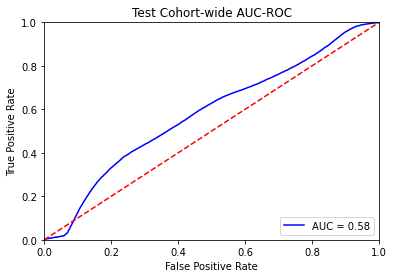

In [175]:
#from sophie's code - viz. the curve 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# fpr and tpr of all thresohlds
true = ground_truth
preds = probabilities[:, 1]
fpr, tpr, threshold = metrics.roc_curve(true, preds)

#get the metrics 
roc_auc = metrics.auc(fpr, tpr)

#plot
plt.title('Test Cohort-wide AUC-ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
!nvidia-smi

Sat Dec 24 02:12:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   37C    P0    54W / 300W |   3046MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [17]:
torch.cuda.device_count()

4